# OLS Analysis Using Full PSU dataset

In [1]:
#Import required packages
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [2]:
def format_date(df_date):
    """
    Splits Meeting Times and Dates into datetime objects where applicable using regex.
    """
    df_date['Days'] = df_date['Meeting_Times'].str.extract('([^\s]+)', expand=True)
    df_date['Start_Date'] = df_date['Meeting_Dates'].str.extract('([^\s]+)', expand=True)
    df_date['Year'] = df_date['Term'].astype(str).str.slice(0,4)
    df_date['Quarter'] = df_date['Term'].astype(str).str.slice(4,6)
    df_date['Term_Date'] = pd.to_datetime(df_date['Year'] + df_date['Quarter'], format='%Y%m')
    df_date['End_Date'] = df_date['Meeting_Dates'].str.extract('(?<=-)(.*)(?= )', expand=True)
    df_date['Start_Time'] = df_date['Meeting_Times'].str.extract('(?<= )(.*)(?=-)', expand=True)
    df_date['Start_Time'] = pd.to_datetime(df_date['Start_Time'], format='%H%M')
    df_date['End_Time'] = df_date['Meeting_Times'].str.extract('((?<=-).*$)', expand=True)
    df_date['End_Time'] = pd.to_datetime(df_date['End_Time'], format='%H%M')
    df_date['Duration_Hr'] = ((df_date['End_Time'] - df_date['Start_Time']).dt.seconds)/3600
    return df_date

def format_xlist(df_xl):
    """
    revises % capacity calculations by using Max Enrollment instead of room capacity.  
    """
    df_xl['Cap_Diff'] = np.where(df_xl['Xlst'] != '', 
                                   df_xl['Max_Enrl'].astype(int) - df_xl['Actual_Enrl'].astype(int), 
                                   df_xl['Room_Capacity'].astype(int) - df_xl['Actual_Enrl'].astype(int)) 
    df_xl = df_xl.loc[df_xl['Room_Capacity'].astype(int) < 999]

    return df_xl   
    

## Partitioning a dataset in training and test sets

In [3]:
pd.set_option('display.max_rows', None)  


df = pd.read_csv('data/PSU_master_classroom_91-17.csv', dtype={'Schedule': object, 'Schedule Desc': object})
df = df.fillna('')

df = format_date(df)
# Avoid classes that only occur on a single day
df = df.loc[df['Start_Date'] != df['End_Date']]

#terms = [199104, 199204, 199304, 199404, 199504, 199604, 199704, 199804, 199904, 200004, 200104, 200204, 200304, 200404, 200504, 200604, 200704, 200804, 200904, 201004, 201104, 201204, 201304, 201404, 201504, 201604]
terms = [200604, 200704, 200804, 200904, 201004, 201104, 201204, 201304, 201404, 201504, 201604]
df = df.loc[df['Term'].isin(terms)]
df = df.loc[df['Online Instruct Method'] != 'Fully Online']

# Calculate number of days per week and treat Sunday condition
df['Days_Per_Week'] = df['Days'].str.len()
df['Room_Capacity'] = df['Room_Capacity'].apply(lambda x: x if (x != 'No Data Available') else 0)
df['Building'] = df['ROOM'].str.extract('([^\s]+)', expand=True)

df_cl = format_xlist(df)
df_cl['%_Empty'] = df_cl['Cap_Diff'].astype(float) / df_cl['Room_Capacity'].astype(float)

# Normalize the results
df_cl['%_Empty'] = df_cl['Actual_Enrl'].astype(np.float32)/df_cl['Room_Capacity'].astype(np.float32)
df_cl = df_cl.replace([np.inf, -np.inf], np.nan).dropna()


C:\Users\kms22\AppData\Local\Continuum\Miniconda3\envs\data-science\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\kms22\AppData\Local\Continuum\Miniconda3\envs\data-science\lib\site-packages\ipykernel\__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [4]:
from sklearn.preprocessing import LabelEncoder

df_cl = df_cl.sample(n = 15000)

# Save as a 1D array. Otherwise will throw errors.
y = np.asarray(df_cl['%_Empty'], dtype="|S6")
df_cl = df_cl[['Dept', 'Class', 'Days', 'Start_Time', 'ROOM', 'Term', 'Room_Capacity', 'Building']]

cat_columns = ['Dept', 'Class', 'Days', 'Start_Time', 'ROOM', 'Building']

for column in cat_columns:
    room_mapping = {label: idx for idx, label in enumerate(np.unique(df_cl['{0}'.format(column)]))}
    df_cl['{0}'.format(column)] = df_cl['{0}'.format(column)].map(room_mapping)

from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version
    
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

X = df_cl.iloc[:, 1:].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=0)


## Determine Feature Importances

## Test Prediction Results

Class, Term, and Start Times are the three most important factors in determining the percentage of empty seats expected.

from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed)
cart = DecisionTreeClassifier()
num_trees = 25
model = BaggingClassifier(base_estimator=cart, n_estimators=num_trees, random_state=seed)
results = model_selection.cross_val_score(model, X, y, cv=kfold)
print(results.mean())

LR: 0.067714 (0.006604)
LDA: 0.063810 (0.004949)
KNN: 0.052667 (0.006432)
CART: 0.098381 (0.007761)
NB: 0.043048 (0.005960)
SVM: 0.055143 (0.007395)


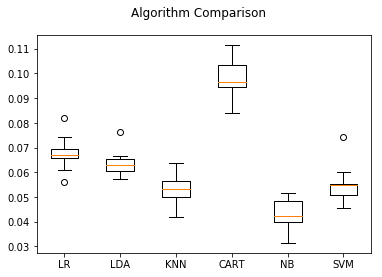

In [8]:
# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring, n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()